# Inpsect Bias Model

Manually inspect bias model.

Empirically, I've observed bias model training can fail if:
1. Training non-peak regions are not thresholded to be below a certain count threshold
2. Training on many non-peak regions (e.g. 70k). 40-50k seems to have worked before.

You can tweak the `--threshold_factor` paramter above or below the default 0.5 to increase or decrease the count threshold.

Check below to see an examples of how one can quickly identify failed bias models (e.g. AP1 response). In general, the visual inspection below is not sufficient to ensure proper bias model training. You'll have to do the following to be more certain:
1. MoDISco on counts and profile of bias model and inspect them to ensrue no TF motif is picked up
2. Train a ChromBPNet model with the bias model, run MoDISco on profile and ensure no tn5 motif is picked up.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data
from metrics import softmax 

## Load Data

In [2]:
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll}):
    model_bias = tf.keras.models.load_model("../pretrained/c1.h5")    

In [3]:
INP_LEN = model_bias.input_shape[1]
OUT_LEN = model_bias.output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [4]:
TEST_CHR = ["chr1"]
VAL_CHR = ["chr8", "chr10"]

In [5]:
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data("/users/surag/oak/projects/scATAC-reprog/bpnet/data/20210818_n62599/peaks/overlap_merged/cluster_idx1.bed", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/data/20210818_n62599/peaks/gc_neg/cluster_idx1.gc.neg.bed", 
                   "/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta", 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx1.bw",
                   TEST_CHR, INP_LEN, OUT_LEN)

## Motif Inspection

Shoudl not respond to TF motifs. TF motifs picked should be based on prevalance of motif in cell type. E.g. AP1 is super common in fibroblasts.

By "response", we are looking for elevated profile signal that extends beyond the central motif site.

In [6]:
def bias_check_preds_for_motif(bias_model, seqs, motif):
    w_mot_seqs = seqs.copy()
    MID = bias_model.input_shape[1]//2 - len(motif)//2
    w_mot_seqs[:, MID:MID+len(motif)] = one_hot.dna_to_one_hot([motif])
    
    raw_seqs_pred_prof, raw_seqs_pred_cts = bias_model.predict(seqs,verbose=True)
    w_mot_seqs_pred_prof, w_mot_seqs_pred_cts = bias_model.predict(w_mot_seqs, verbose=True)
    
    return softmax(raw_seqs_pred_prof), softmax(w_mot_seqs_pred_prof), raw_seqs_pred_cts, w_mot_seqs_pred_cts

In [7]:
def bias_check_plot_tracks(raw_bias, raw_mot_bias, start=450, end=550):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    
    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

### tn5

In [8]:
raw_bias, bias_w_tn5, raw_bias_cts, bias_w_tn5_cts = bias_check_preds_for_motif(model_bias, test_nonpeaks_seqs[:1000], "CAGTCCTGGACTG")

32/32 [==============================] - 0s 14ms/step


In [9]:
np.median(bias_w_tn5_cts-raw_bias_cts)

0.0039379597

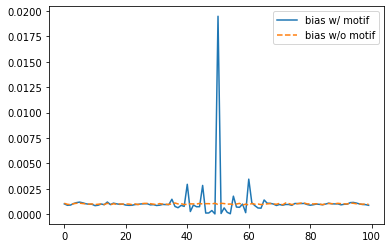

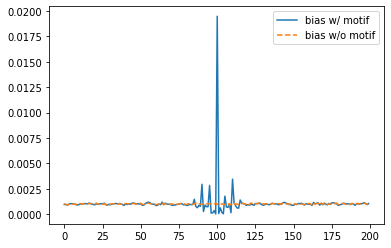

In [10]:
bias_check_plot_tracks(raw_bias, bias_w_tn5)
bias_check_plot_tracks(raw_bias, bias_w_tn5, 400, 600)

This looks ok.

### AP1

In [11]:
raw_bias, bias_w_ap1, raw_bias_cts, bias_w_ap1_cts = bias_check_preds_for_motif(model_bias, test_nonpeaks_seqs[:3000], "ATGAGTCAT")

94/94 [==============================] - 1s 14ms/step


In [12]:
np.median(bias_w_ap1_cts-raw_bias_cts)

-0.002045989

**Example where bias model doesn't pick up TF motif**

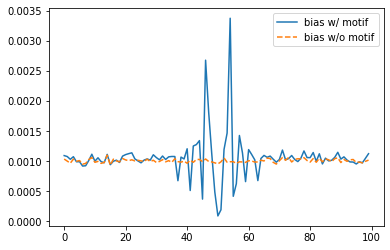

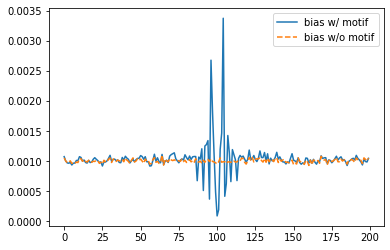

In [100]:
bias_check_plot_tracks(raw_bias, bias_w_ap1)
bias_check_plot_tracks(raw_bias, bias_w_ap1, 400, 600)

**Example where bias model picks up TF motif**

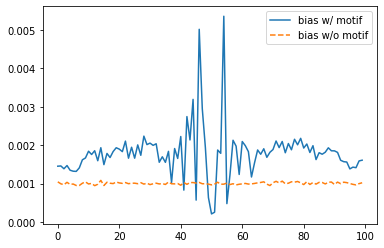

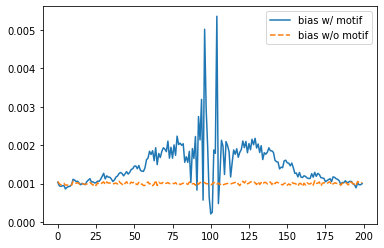

In [47]:
bias_check_plot_tracks(raw_bias, bias_w_ap1)
bias_check_plot_tracks(raw_bias, bias_w_ap1, 400, 600)

Note that the signal is elevated up to 50 bp on either side after insertion of motif! This suggests the model is picking up TF associated signal!

In general performing MoDISco on profile would reveal all motifs learned.

### NFI

In [14]:
raw_bias, bias_w_nfi, raw_bias_cts, bias_w_nfi_cts = bias_check_preds_for_motif(model_bias, test_nonpeaks_seqs[:3000], "TTGGCCCTGAGCCAA")

94/94 [==============================] - 1s 14ms/step


In [15]:
np.median(bias_w_nfi_cts-raw_bias_cts)

0.0020623207

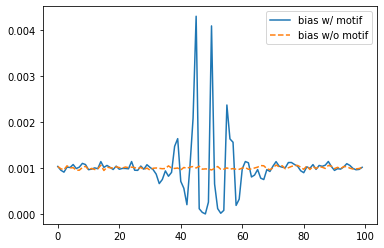

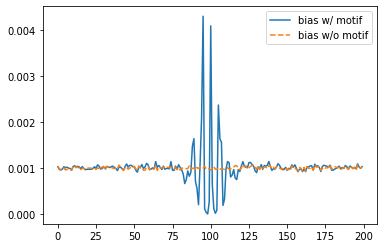

In [16]:
bias_check_plot_tracks(raw_bias, bias_w_nfi)
bias_check_plot_tracks(raw_bias, bias_w_nfi, 400, 600)

This looks ok.

### CTCF

In [17]:
raw_bias, bias_w_ctcf, raw_bias_cts, bias_w_ctcf_cts = bias_check_preds_for_motif(model_bias, test_nonpeaks_seqs[:3000], "CCCCGGCGCCCCCTGGTGGC")

94/94 [==============================] - 1s 14ms/step


In [18]:
np.median(bias_w_ctcf_cts-raw_bias_cts)

0.00788784

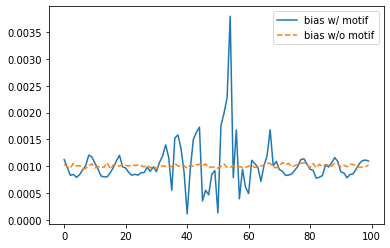

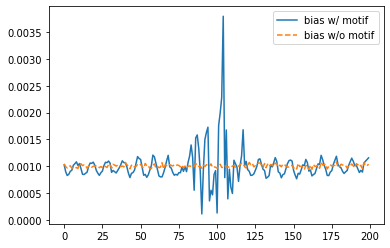

In [19]:
bias_check_plot_tracks(raw_bias, bias_w_ctcf)
bias_check_plot_tracks(raw_bias, bias_w_ctcf, 400, 600)

This looks ok.